In [1]:
words = open("names.txt", 'r').read().splitlines()

In [2]:
special_char = '.'
different_chars_in_dataset = sorted(list(set(''.join(words))))
mapping_char_to_index = {s:i+1 for i,s in enumerate(different_chars_in_dataset)}
mapping_char_to_index[special_char] = 0
mapping_index_to_char = {i:s for s,i in mapping_char_to_index.items()}

In [3]:
import torch
import torch.nn.functional as F

X, Y = [], []
block_size = 3
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        index_ch = mapping_char_to_index[ch]
        X.append(context)
        Y.append(index_ch)
        context = context[1:] + [index_ch]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [4]:
X[0:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [5]:
Y[0:5]

tensor([ 5, 13, 13,  1,  0])

In [6]:
X.shape,Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [7]:
# Building embedding tables
C = torch.randn((27, 2))

In [8]:
C[5]

tensor([-0.0012,  0.0109])

In [9]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.0012,  0.0109])

In [10]:
X[0]

tensor([0, 0, 0])

In [11]:
C[X[0]]

tensor([[-1.7227,  0.3989],
        [-1.7227,  0.3989],
        [-1.7227,  0.3989]])

In [12]:
C[X[0:2]]

tensor([[[-1.7227e+00,  3.9892e-01],
         [-1.7227e+00,  3.9892e-01],
         [-1.7227e+00,  3.9892e-01]],

        [[-1.7227e+00,  3.9892e-01],
         [-1.7227e+00,  3.9892e-01],
         [-1.2074e-03,  1.0873e-02]]])

In [13]:
emb = C[X]

In [14]:
W1 = torch.randn((6, 100))

In [15]:
b1 = torch.randn(100)

In [16]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([228146, 6])

In [17]:
torch.cat(torch.unbind(emb, dim=1), 1).shape

torch.Size([228146, 6])

In [18]:
a =torch.arange(18)

In [19]:
a.view(6,3)

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])

In [20]:
a.storage()

/var/folders/55/krymh2611jx50w2xfqbmf70h0000gn/T/ipykernel_40350/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [21]:
h = torch.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1)

In [22]:
h.shape

torch.Size([228146, 100])

In [23]:
b1.shape

torch.Size([100])

In [24]:
# b1 will be copied to the 228146

In [25]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [26]:
logits = (h @ W2) + b2

In [27]:
logits.shape

torch.Size([228146, 27])

In [28]:
counts = logits.exp()

In [29]:
probs = counts / counts.sum(1, keepdim=True)

In [30]:
probs.shape

torch.Size([228146, 27])

In [31]:
probs[0].sum()

tensor(1.0000)

In [32]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [33]:
loss = -probs[torch.arange(probs.shape[0]),Y].log().mean()

In [34]:
loss

tensor(16.2223)

In [35]:
# reasons for cross entropy
# forward pass is more efficent (fused kernels)
# backward pass is more efficient (fused kernels)
# much more numerically well behaved
F.cross_entropy(logits, Y)

tensor(16.2223)

In [36]:
emb.shape

torch.Size([228146, 3, 2])

In [37]:
emb.view(-1,6).shape

torch.Size([228146, 6])

### Putting all together

### Finding a good learning rate
To find a good learning rate we will try different learning rates, one per step and take the learning rate with minimum loss (Need to understand better why) 

In [38]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 =  torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

In [39]:
learning_rates_exp = torch.linspace(-3,0,1000)
learning_rates = 10 ** learning_rates_exp

In [40]:
for p in parameters:
    p.requires_grad=True

losses = []
used_learning_rates = []
for i in range(1000):
    # minibatch indices
    mini_batch_indices = torch.randint(0, X.shape[0], (32,))
    
    emb = C[X[mini_batch_indices]]
    Y_mini_batch = Y[mini_batch_indices]
    
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # size 228146, 100 
    logits = h @ W2 + b2 # size 228146, 27
    loss = F.cross_entropy(logits, Y_mini_batch)
    losses.append(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = learning_rates[i]
    used_learning_rates.append(learning_rates_exp[i].item())
    for p in parameters:
        p.data += -learning_rate * p.grad

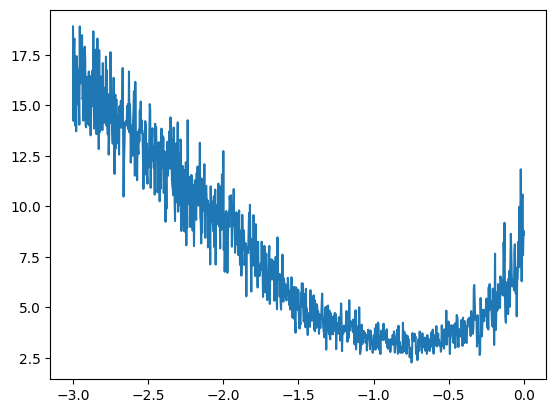

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(used_learning_rates, losses)

In [42]:
print(losses.index(min(losses)))

750


In [43]:
print(learning_rates[658])

tensor(0.0946)


We notice here the learning rate with minimum loss is of 0.0946

### Putting it all together
We will build here a neural network using a generator with a seed for reproducibility

The neural network will be:

C - An embedding layer of dimension of 2. 27 is the number of parameters

W1 - weight matrix part of the hidden layer - size 6 because we have 3 chars in input embedded as arrays of size 2 x 100

b1 - bias

activation function - tanh

W2 - weight matrix part of the linear regression size 100x27

b2 - bias vector

softmax function to get probabilities per character

cross entropy loss function

In [44]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 =  torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

In [45]:
for p in parameters:
    p.requires_grad=True

losses = []
for i in range(10000):
    # minibatch indices
    mini_batch_indices = torch.randint(0, X.shape[0], (32,))
    
    emb = C[X[mini_batch_indices]]
    Y_mini_batch = Y[mini_batch_indices]
    
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # size 228146, 100 
    logits = h @ W2 + b2 # size 228146, 27
    loss = F.cross_entropy(logits, Y_mini_batch)
    losses.append(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.0946 * p.grad

In [46]:
# Loss for the whole dataset
emb = C[X]

h = torch.tanh(emb.view(-1,6) @ W1 + b1) # size 228146, 100 
logits = h @ W2 + b2 # size 228146, 27
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.437371015548706


### Split into training, test, validation
We will split the dataset into training, validation and test set. We will use different parameters to train our models in the training set. The validation set will allow us to check the performance of each model and to select the best. The test set will allow us to confirm the performance of the selected model.

In [47]:
import torch
import torch.nn.functional as F
import random

def __build_mapping_index_to_char(words: list) -> dict:
    special_char = '.'
    different_chars_in_dataset = sorted(list(set(''.join(words))))
    mapping_char_to_index = {s:i+1 for i,s in enumerate(different_chars_in_dataset)}
    mapping_char_to_index[special_char] = 0
    mapping_index_to_char = {i:s for s,i in mapping_char_to_index.items()}
    return mapping_index_to_char, mapping_char_to_index
    

def build_training_validation_test_sets(words: list, ratio_training_set: float, ratio_validation_set: float, ratio_test_set: float, block_size: int):
    assert ratio_training_set + ratio_validation_set + ratio_test_set == 1.0
    assert block_size > 0
    
    mapping_index_to_char = __build_mapping_index_to_char(words)
    
    random.seed(42)
    random.shuffle(words)
    
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            index_ch = mapping_char_to_index[ch]
            X.append(context)
            Y.append(index_ch)
            context = context[1:] + [index_ch]
    
    number_of_elements_in_training_set = int(len(X) * ratio_training_set)
    number_of_elements_in_validation_set = int(len(X) * ratio_validation_set)
    X_training, X_validation, X_test = torch.tensor_split(torch.tensor(X), (number_of_elements_in_training_set, number_of_elements_in_training_set + number_of_elements_in_validation_set), dim=0)
    Y_training, Y_validation, Y_test = torch.tensor_split(torch.tensor(Y), (number_of_elements_in_training_set, number_of_elements_in_training_set + number_of_elements_in_validation_set), dim=0)
    
    return X_training, Y_training, X_validation, Y_validation, X_test, Y_test, mapping_index_to_char, mapping_char_to_index

    

In [48]:
X_training, Y_training, X_validation, Y_validation, X_test, Y_test, mapping_index_to_char, mapping_char_to_index = build_training_validation_test_sets(words, 0.8, 0.1, 0.1, 3)

In [78]:
class MultiLayerPerceptronNN:

    def __init__(self, hidden_layer_size: int, number_of_steps: int, learning_rate: float, mini_batch_size: int, X_training: torch.tensor, Y_training: torch.tensor, X_validation: torch.tensor, Y_validation: torch.tensor, block_size: int, embeddings_size: int, mapping_index_to_char: dict[int, str], mapping_char_to_index: dict[str, int]):
        self.hidden_layer_size = hidden_layer_size
        g = torch.Generator().manual_seed(42) 
        self.block_size = block_size
        self.embeddings_size = embeddings_size
        self.C = torch.randn((27, 2), generator=g) # for now we dont change embeddings size
        self.W1 = torch.randn((self.block_size * self.embeddings_size, hidden_layer_size), generator=g)
        self.b1 =  torch.randn(hidden_layer_size, generator=g)
        self.W2 = torch.randn((hidden_layer_size,27), generator=g)
        self.b2 = torch.randn(27, generator=g)
        self.number_of_steps = number_of_steps
        self.learning_rate = learning_rate
        self.trained = False
        self.C.requires_grad = True
        self.W1.requires_grad = True
        self.b1.requires_grad = True
        self.W2.requires_grad = True
        self.b2.requires_grad = True
        self.losses = []
        self.mini_batch_size = mini_batch_size
        self.X_training = X_training 
        self.Y_training = Y_training
        self.X_validation = X_validation
        self.Y_validation = Y_validation
        self.mapping_index_to_char = mapping_index_to_char
        self.mapping_char_to_index = mapping_char_to_index


        
    def train(self):
        if not self.trained:
            losses = []
            for i in range(self.number_of_steps):
                self.C.grad = None
                self.W1.grad = None
                self.b1.grad = None
                self.W2.grad = None
                self.b2.grad = None
                # minibatch indices
                mini_batch_indices = torch.randint(0, self.X_training.shape[0], (self.mini_batch_size,))
    
                emb = self.C[self.X_training[mini_batch_indices]]
                Y_mini_batch = self.Y_training[mini_batch_indices]
    
                h = torch.tanh(emb.view(-1,self.block_size * self.embeddings_size) @ self.W1 + self.b1)
                logits = h @ self.W2 + self.b2 
                loss = F.cross_entropy(logits, Y_mini_batch)
                self.losses.append(loss.item())
                loss.backward()
                self.C.data += -self.learning_rate * self.C.grad
                self.W1.data += -self.learning_rate * self.W1.grad
                self.b1.data += -self.learning_rate * self.b1.grad
                self.W2.data += -self.learning_rate * self.W2.grad
                self.b2.data += -self.learning_rate * self.b2.grad
            self.trained = True
        

    def evaluate(self):
        if self.trained:
            emb = self.C[self.X_validation]
            h = torch.tanh(emb.view(-1,6) @ W1 + b1)
            logits = h @ W2 + b2 
            loss = F.cross_entropy(logits, self.Y_validation)
            return loss
        else:
            raise Exception("Model has to be trained before evaluated") 

    def generate(self, beginning_of_name):
        if self.trained:
            generated_name_tokens = [0] * self.block_size
            req_length = len(beginning_of_name)
            current_index = max(0, self.block_size - req_length)
            for ch in beginning_of_name:
                if current_index >= block_size:
                    generated_name_tokens.append(self.mapping_char_to_index[ch])
                else: 
                    generated_name_tokens[current_index] = self.mapping_char_to_index[ch]
                current_index += 1
            generated_char_index = -1
            while generated_char_index != 0:
                print(generated_name_tokens)
                emb = self.C[generated_name_tokens[-self.block_size:]]
                h = torch.tanh(emb.view(-1,self.block_size * self.embeddings_size) @ self.W1 + self.b1)
                logits = h @ self.W2 + self.b2
                generated_char_index = logits.argmax().item()
                print(generated_char_index)
                generated_name_tokens.append(generated_char_index)
            output = ""
            for index in generated_name_tokens:
                if index != 0:
                    output = output + self.mapping_index_to_char[index]
            return output
        else:
            raise Exception("Model has to be trained before generation") 

mlp = MultiLayerPerceptronNN(hidden_layer_size=100, number_of_steps=10000, learning_rate=0.1, mini_batch_size=128, X_training=X_training, Y_training=Y_training, X_validation=X_validation, Y_validation=Y_validation, block_size=3, embeddings_size=2, mapping_index_to_char=mapping_index_to_char, mapping_char_to_index=mapping_char_to_index)
mlp.train()
print(mlp.losses[-1])
mlp.evaluate()


2.3535635471343994


tensor(2.6607, grad_fn=<NllLossBackward0>)

In [83]:
mlp.generate("tinas")

[20, 9, 14, 1, 19]
1
[20, 9, 14, 1, 19, 1]
0


'tinasa'

### Let's visualize the embeddings

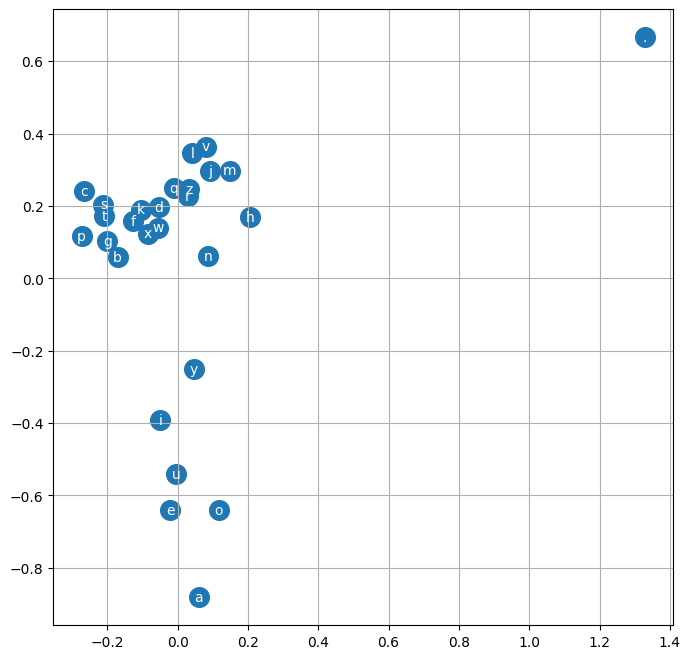

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(mlp.C[:,0].data, mlp.C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(mlp.C[i,0].item(), mlp.C[i,1].item(), mapping_index_to_char[i], ha="center", va="center", color="white")
plt.grid("minor")